# MLP实现方式

* 1958 年，心理学家Rosenblatt 提出 Perceptron（感知机）模型
* 1984 年，Hinton等人提出的Bolzmann机
* 1986 年，Rumelhart、Hinton、Williams 提出反向传播(BP)算法，随之，MLP（Multi-Layer Perceptron，多层感知机，有隐层）变得可行，并流行
* **MLP 可以看做最原始的神经网络**，并在此基础上逐渐发展出各种 NN 和 DeepNN 网络模型



# Data

In [1]:
import os
import numpy as np
from mxnet import ndarray as nd, autograd as ag, gluon
from dataloader import DataLoader

In [2]:
dl = DataLoader(os.environ["HOME"] + '/.datasets/Han.Xiao/fashion-mnist/')
train_img,train_labels = dl.get_data(kind='train')
test_img,test_labels = dl.get_data(kind='t10k')

train_img_nd = nd.array(train_img).astype(np.float32)/255
train_lab_nd = nd.array(train_labels).astype(np.float32)
test_img_nd = nd.array(test_img).astype(np.float32)/255
test_lab_nd = nd.array(test_labels).astype(np.float32)

def data_iter(batch_size=100, kind='train'):
    if kind != 'train':
        idx = list(range(len(test_labels)))
        for i in range(0,len(test_labels), batch_size):
            j = nd.array(idx[i:min(i+batch_size,len(test_labels))])
            yield nd.take(test_img_nd,j), nd.take(test_lab_nd,j)
    else:
        idx = list(range(len(train_labels)))
        for i in range(0,len(train_labels), batch_size):
            j = nd.array(idx[i:min(i+batch_size,len(train_labels))])
            yield nd.take(train_img_nd,j), nd.take(train_lab_nd,j)

# Model

In [3]:
num_inputs = 28*28
num_outputs = 10

num_hidden = 256
weight_scale = .01

# MXNet 的公式是 y=XW+b，吴恩达的公式是 y=WX+b，所以两者W的shape定义是相反的。
W1 = nd.random_normal(shape=(num_inputs,num_hidden), scale=weight_scale)
b1 = nd.zeros(num_hidden)

W2 = nd.random_normal(shape=(num_hidden,num_outputs),scale=weight_scale)
b2 = nd.zeros(num_outputs)

params = [W1,b1,W2,b2]
for p in params:
    p.attach_grad()

In [4]:
def relu(X):
    return nd.maximum(X,0)

In [5]:
def net(X):
    X = X.reshape((-1, num_inputs))
    h1 = relu(nd.dot(X,W1) + b1)
    output = nd.dot(h1,W2) + b2
    return output

In [6]:
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

# Train

In [7]:
def SGD(params, lr):
    for p in params:
        p[:] = p - lr*p.grad

In [8]:
def accuracy(yhat,y):
    return nd.mean(yhat.argmax(axis=1)==y).asscalar()

In [448]:
learning_rate = .2
batch_size = 100
epoches = 100

import datetime
t1 = datetime.datetime.now()

for epoch in range(epoches):
    train_loss = 0.
    train_accu = 0.
    
    for data, label in data_iter(batch_size=batch_size):
        with ag.record():
            yhat = net(data)
            loss = softmax_cross_entropy(yhat,label)
        loss.backward()
        
        SGD(params, learning_rate/batch_size)
                
        train_loss += nd.mean(loss).asscalar()
        train_accu += accuracy(yhat,label)

    print("epoch:%d; loss:%f; accu:%f" % (epoch, 
                    train_loss/len(train_labels)*batch_size,
                    train_accu/len(train_labels)*batch_size))
    
print(datetime.datetime.now()-t1)

loss:0.557523; accu:0.865517
loss:0.269407; accu:0.901767
loss:0.235381; accu:0.913750
loss:0.213467; accu:0.921200
loss:0.192387; accu:0.928800
loss:0.179253; accu:0.933400
loss:0.165940; accu:0.937867
loss:0.154595; accu:0.942883
loss:0.147280; accu:0.945500
loss:0.135391; accu:0.950050
loss:0.133376; accu:0.950517
loss:0.126359; accu:0.953283
loss:0.127837; accu:0.952583
loss:0.114598; accu:0.958800
loss:0.111142; accu:0.959700
loss:0.109361; accu:0.960300
loss:0.103520; accu:0.962217
loss:0.101846; accu:0.963083
loss:0.096366; accu:0.965633
loss:0.096399; accu:0.965850
loss:0.094798; accu:0.966400
loss:0.089052; accu:0.968700
loss:0.086159; accu:0.969983
loss:0.086978; accu:0.968783
loss:0.083878; accu:0.970667
loss:0.082075; accu:0.971200
loss:0.080748; accu:0.972250
loss:0.076769; accu:0.973083
loss:0.076423; accu:0.973583
loss:0.078983; accu:0.972233
loss:0.077286; accu:0.973233
loss:0.070920; accu:0.974633
loss:0.071808; accu:0.975150
loss:0.069359; accu:0.975783
loss:0.063034;

# Test

In [446]:
yhat = net(train_img_nd).argmax(axis=1).asnumpy()
y = train_lab_nd.asnumpy()
y.shape

(60000,)

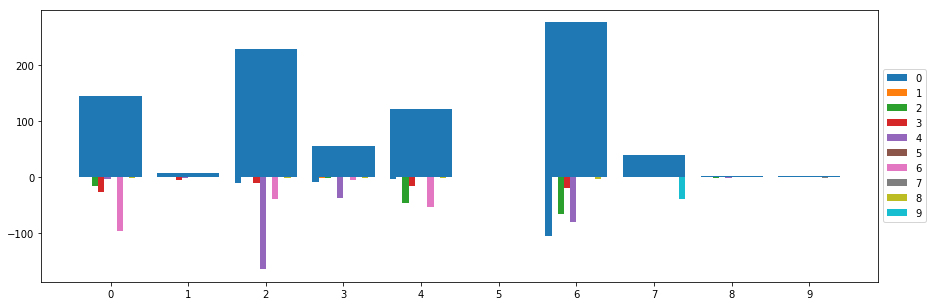

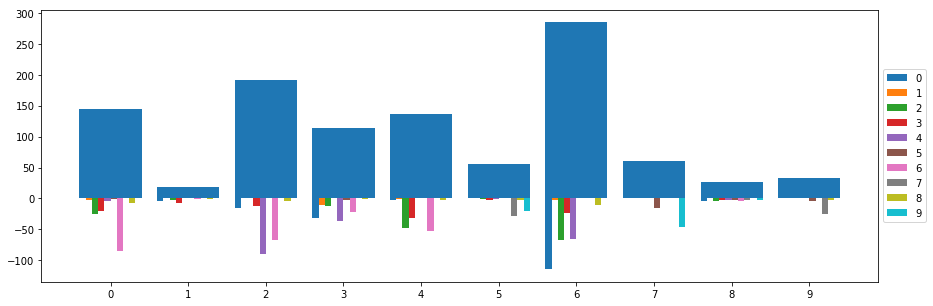

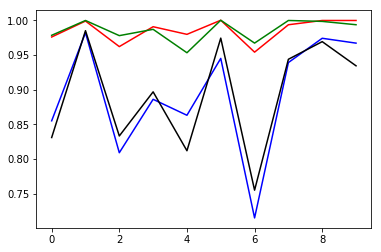

In [440]:
from statiser import Statistics
train_statistics = Statistics(net(train_img_nd).argmax(axis=1).asnumpy(), 
                              train_lab_nd.asnumpy())
test_statistics = Statistics(net(test_img_nd).argmax(axis=1).asnumpy(), 
                             test_lab_nd.asnumpy())
train_statistics.show()
test_statistics.show()
plt.plot(range(10),train_statistics.Recall(),'r')
plt.plot(range(10),train_statistics.Precision(),'g')
plt.plot(range(10),test_statistics.Recall(),'b')
plt.plot(range(10),test_statistics.Precision(),'k')
plt.show()